In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import table
from astropy.io import fits

from ekfplot import plot as ek

from agrias import utils
import reader

In [8]:
merian = table.Table(fits.getdata('/Users/kadofong/Downloads/Merian_DR1_photoz_EAZY_v1.2.fits',1))
ms = reader.merianselect ( merian )
_galex = reader.galexcrossmatch ()
overlap = ms.index.intersection(_galex.index)

merian_sources = ms.reindex(overlap)

_galex = _galex.sort_values('fuv_exptime', ascending=False)

galex = _galex.loc[~_galex.index.duplicated(keep='first')].reindex(overlap).reset_index()

[merianselect] Only choosing sources at 0.070<z_phot<0.090
[merianselect] Only choosing sources with i_cModelmag_Merian < 22.0
[merianselect] only choosing sources with cmodel/gaap(i) > 1.3


In [12]:
catalog_halum = pd.read_csv ( '/Users/kadofong/Desktop/merian_catalog_halum.csv', index_col=0)

In [14]:
lha_df = pd.read_csv('../local_data/output/lha_df.csv', index_col=0)

In [28]:
lha_df.dropna().head()

,LHa,u_LHa
M3324901172162100616,0.010332,0.002168
M3324940754580701052,0.060923,0.005213
M3325050705743463287,0.534259,0.028189
M3325094686208586524,0.032752,0.004580
M3460233461355267333,0.059971,0.003687


In [26]:
catalog_halum.head()

,LHa,u_LHa,LFUV,u_LFUV
M3324835201464449405,2.492887e+40,2.337910e+39,2.828581e+27,1.109446e+27
M3324848395603966290,1.660511e+39,1.973038e+39,5.373201e+27,1.690788e+27
M3324852793650467962,3.197020e+40,4.391310e+39,3.953953e+27,1.471401e+27
M3324857191696979637,6.269890e+39,1.661784e+39,inf,-inf
M3324865987790013450,1.344978e+41,5.868456e+39,9.561092e+27,1.257068e+27


In [31]:
-2.5*np.log10(1e-9/3631.)

31.40006562228223

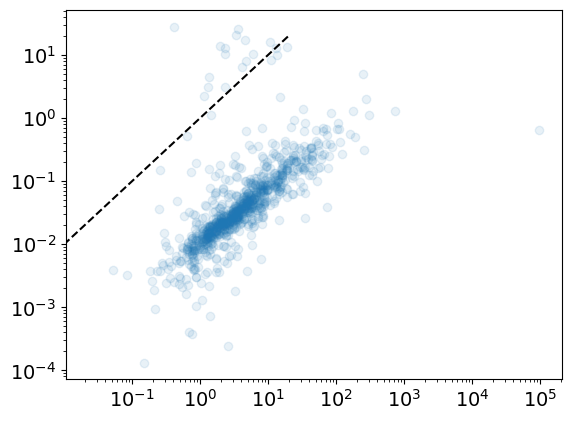

In [30]:
plt.scatter ( 
    catalog_halum['LHa']/1e40,
    lha_df.reindex(catalog_halum.index)['LHa'], 
    alpha=0.1
)
xs = np.linspace(0., 20.,10)
plt.plot(xs,xs,color='k', ls='--')
ek.loglog()